In [1]:
import numpy as np
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Constants
batch_size = 128
num_classes = 10
input_dim = 784

# Hyperparameters
lr = 0.05
hidden_dim = 1200

In [4]:
# iris = datasets.load_iris()
training_data = datasets.MNIST(root='data', train=True, download=True, transform=ToTensor())
training_set, validation_set = torch.utils.data.random_split(training_data, [50000, 10000])
test_data = datasets.MNIST(root='data', train=False, download=True, transform=ToTensor())

training_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [5]:
num_batches = int(len(training_set) / batch_size) + 1
denom = 2 ** num_batches  - 1

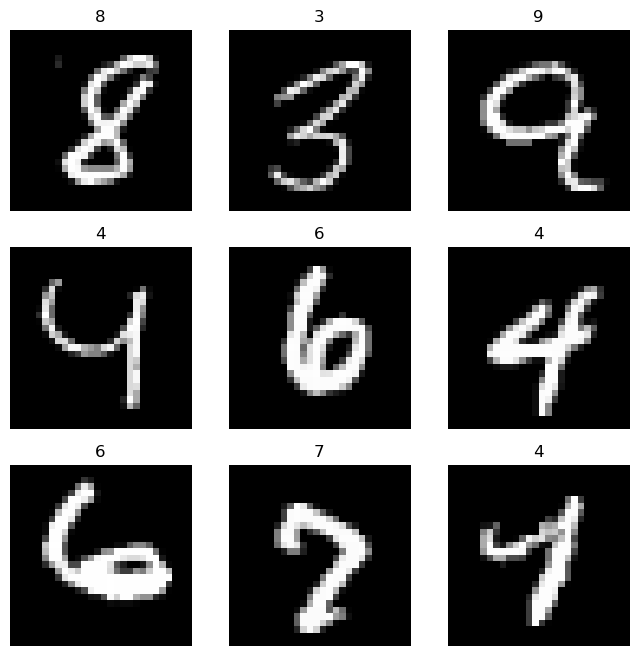

In [6]:
# Visualize the data
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

# No need to normalize. The data values are already between 0 and 1

In [7]:
# print(img.shape)
print(len(training_set),len(validation_set))

50000 10000


In [8]:
# x, y = torch.from_numpy(X).float(), torch.from_numpy(Y).long()
# x.shape, y.shape

In [9]:
sigma1 = 10 ** log_sigma1

model = nn.Sequential(
    nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=hidden_dim, out_features=num_classes, bias=False),
)

In [10]:
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0)

In [11]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        inputs = inputs.view(-1, 784)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        ################## WE CAN AVERAGE ACROSS MULTIPLE W SAMPLES HERE BEFORE DOING loss.backward() #########################
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = ce_loss(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 100 == 99:
            last_loss = running_loss / 100 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [12]:
# Initializing in a separate cell so we can easily add more epochs to the same run
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/MNIST_trainer_{}'.format(timestamp))
epoch_number = 0

val_loss = []
val_accuracy = []

test_loss = []
test_accuracy = []

EPOCHS = 300

best_vloss = 1_000_000.
num_vbatches = int(len(validation_set) / batch_size) + 1
vdenom = 2 ** num_vbatches - 1

num_tbatches = int(len(test_data) / batch_size) + 1
tdenom = 2 ** num_tbatches - 1

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.3)

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    model.train(False)

    running_vloss = 0.0
    correct = 0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        vinputs = vinputs.view(-1, 784)
        voutputs = model(vinputs)
        _, predicted = torch.max(voutputs, 1)
        correct += torch.sum(vlabels == predicted)
        vloss = ce_loss(voutputs, vlabels)
        running_vloss += vloss.item()

    avg_vloss = running_vloss / (i + 1)
    val_loss.append(avg_vloss)
    val_accuracy.append(100 * float(correct)/ len(validation_set))
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
    print('valid accuracy {}'.format(val_accuracy[-1]))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = './models/vanilla-SGD/model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)
    
    # Update the learning rate
    scheduler.step()
    
    running_tloss = 0.0
    correct = 0

    for i, tdata in enumerate(test_loader):
        tinputs, tlabels = tdata
        tinputs = tinputs.view(-1, 784)
        toutputs = model(tinputs)
        _, predicted = torch.max(toutputs, 1)
        correct += torch.sum(tlabels == predicted)
        tloss = ce_loss(voutputs, vlabels)
        running_tloss += tloss.item()

    avg_tloss = running_tloss / (i + 1)

    test_loss.append(avg_tloss)
    test_accuracy.append(100 * float(correct)/ len(test_data))
    print('test accuracy {}'.format(test_accuracy[-1]))

    epoch_number += 1

EPOCH 1:
  batch 100 loss: 1.9667944765090943
  batch 200 loss: 0.8174952438473702
  batch 300 loss: 0.5054942998290062
LOSS train 0.5054942998290062 valid 0.4072777289378492
valid accuracy 88.12
test accuracy 89.14
EPOCH 2:
  batch 100 loss: 0.36982057183980943
  batch 200 loss: 0.33762901797890665
  batch 300 loss: 0.32938731238245966
LOSS train 0.32938731238245966 valid 0.32427893503557276
valid accuracy 90.6
test accuracy 91.56
EPOCH 3:
  batch 100 loss: 0.28742374569177626
  batch 200 loss: 0.28352433115243914
  batch 300 loss: 0.2704421563446522
LOSS train 0.2704421563446522 valid 0.26748400360723085
valid accuracy 92.14
test accuracy 92.93
EPOCH 4:
  batch 100 loss: 0.25631081461906435
  batch 200 loss: 0.23514131888747214
  batch 300 loss: 0.2216703938692808
LOSS train 0.2216703938692808 valid 0.22927808752165565
valid accuracy 93.54
test accuracy 94.12
EPOCH 5:
  batch 100 loss: 0.2146958953887224
  batch 200 loss: 0.20657061785459518
  batch 300 loss: 0.19668228641152383
LOSS

test accuracy 97.93
EPOCH 38:
  batch 100 loss: 0.01333402045769617
  batch 200 loss: 0.012850103268865496
  batch 300 loss: 0.014435644382610918
LOSS train 0.014435644382610918 valid 0.0697507777168781
valid accuracy 97.86
test accuracy 97.98
EPOCH 39:
  batch 100 loss: 0.011887112522963435
  batch 200 loss: 0.012153042950667442
  batch 300 loss: 0.013184712016955018
LOSS train 0.013184712016955018 valid 0.07067783937282578
valid accuracy 97.81
test accuracy 97.98
EPOCH 40:
  batch 100 loss: 0.010117317198310048
  batch 200 loss: 0.013924552302341908
  batch 300 loss: 0.011877249388489872
LOSS train 0.011877249388489872 valid 0.06961728311792205
valid accuracy 97.85
test accuracy 97.97
EPOCH 41:
  batch 100 loss: 0.010926876233424991
  batch 200 loss: 0.010476822792552411
  batch 300 loss: 0.01172569960122928
LOSS train 0.01172569960122928 valid 0.07107330185561618
valid accuracy 97.88
test accuracy 98.02
EPOCH 42:
  batch 100 loss: 0.010729069134686142
  batch 200 loss: 0.01001776659

  batch 200 loss: 0.002639779785531573
  batch 300 loss: 0.0028306024632183836
LOSS train 0.0028306024632183836 valid 0.07393742551956373
valid accuracy 97.97
test accuracy 98.1
EPOCH 75:
  batch 100 loss: 0.00238666185119655
  batch 200 loss: 0.0024417987745255234
  batch 300 loss: 0.0025388921110425147
LOSS train 0.0025388921110425147 valid 0.07410326005914543
valid accuracy 97.94
test accuracy 98.12
EPOCH 76:
  batch 100 loss: 0.0025429992348654194
  batch 200 loss: 0.00246996510628378
  batch 300 loss: 0.0024794576814747417
LOSS train 0.0024794576814747417 valid 0.07432125678545312
valid accuracy 98.0
test accuracy 98.12
EPOCH 77:
  batch 100 loss: 0.0025598466023802756
  batch 200 loss: 0.002355328630656004
  batch 300 loss: 0.0024490471149329097
LOSS train 0.0024490471149329097 valid 0.07499243041406138
valid accuracy 97.93
test accuracy 98.05
EPOCH 78:
  batch 100 loss: 0.0024069851654348897
  batch 200 loss: 0.0022068356408271937
  batch 300 loss: 0.0024118504661601037
LOSS tra

  batch 200 loss: 0.0012492867957917043
  batch 300 loss: 0.001275829160003923
LOSS train 0.001275829160003923 valid 0.07789811819697483
valid accuracy 97.97
test accuracy 98.09
EPOCH 111:
  batch 100 loss: 0.0013123911689035595
  batch 200 loss: 0.0013178450282430277
  batch 300 loss: 0.001233185329765547
LOSS train 0.001233185329765547 valid 0.0775548505325672
valid accuracy 97.98
test accuracy 98.09
EPOCH 112:
  batch 100 loss: 0.001333578463527374
  batch 200 loss: 0.0012391880541690625
  batch 300 loss: 0.0012923386433976703
LOSS train 0.0012923386433976703 valid 0.07781943852152629
valid accuracy 97.99
test accuracy 98.08
EPOCH 113:
  batch 100 loss: 0.0012182389822555707
  batch 200 loss: 0.0012555789051111787
  batch 300 loss: 0.0012798178591765462
LOSS train 0.0012798178591765462 valid 0.07786051313027362
valid accuracy 97.96
test accuracy 98.08
EPOCH 114:
  batch 100 loss: 0.001256419358542189
  batch 200 loss: 0.0012650226222467608
  batch 300 loss: 0.0011793831069371664
LOS

  batch 100 loss: 0.001123302373162005
  batch 200 loss: 0.0010172707040328533
  batch 300 loss: 0.0011200198251754044
LOSS train 0.0011200198251754044 valid 0.07887947054792054
valid accuracy 97.99
test accuracy 98.09
EPOCH 147:
  batch 100 loss: 0.0011005423119058832
  batch 200 loss: 0.0010971373226493597
  batch 300 loss: 0.0009945430344669149
LOSS train 0.0009945430344669149 valid 0.07899108103511832
valid accuracy 98.0
test accuracy 98.08
EPOCH 148:
  batch 100 loss: 0.0010608165834855754
  batch 200 loss: 0.0010639869706938043
  batch 300 loss: 0.0011041210530675016
LOSS train 0.0011041210530675016 valid 0.07900566547000899
valid accuracy 98.0
test accuracy 98.08
EPOCH 149:
  batch 100 loss: 0.0011060516093857587
  batch 200 loss: 0.001089798241155222
  batch 300 loss: 0.0010513897132477723
LOSS train 0.0010513897132477723 valid 0.07900176224404876
valid accuracy 97.98
test accuracy 98.11
EPOCH 150:
  batch 100 loss: 0.0010393684994778596
  batch 200 loss: 0.0010779774785623886


test accuracy 98.12
EPOCH 182:
  batch 100 loss: 0.0008443748082208913
  batch 200 loss: 0.0009570400955271907
  batch 300 loss: 0.0010142942865786608
LOSS train 0.0010142942865786608 valid 0.07979861096938766
valid accuracy 98.02
test accuracy 98.12
EPOCH 183:
  batch 100 loss: 0.0009228690041345545
  batch 200 loss: 0.0008998402915312908
  batch 300 loss: 0.0009841652665636502
LOSS train 0.0009841652665636502 valid 0.07994805456763959
valid accuracy 98.01
test accuracy 98.09
EPOCH 184:
  batch 100 loss: 0.0008776840932841879
  batch 200 loss: 0.0009071146600763314
  batch 300 loss: 0.0009570953866932541
LOSS train 0.0009570953866932541 valid 0.07988091779849198
valid accuracy 98.02
test accuracy 98.08
EPOCH 185:
  batch 100 loss: 0.0009350833456846885
  batch 200 loss: 0.0009516192568116822
  batch 300 loss: 0.0009011157034547068
LOSS train 0.0009011157034547068 valid 0.07989767680086102
valid accuracy 98.01
test accuracy 98.09
EPOCH 186:
  batch 100 loss: 0.0008673863721196539
  bat

LOSS train 0.000793573899572948 valid 0.0804585522465125
valid accuracy 98.01
test accuracy 98.09
EPOCH 218:
  batch 100 loss: 0.0008075175349949859
  batch 200 loss: 0.0008132263748848346
  batch 300 loss: 0.0008476278992020525
LOSS train 0.0008476278992020525 valid 0.08046865779788623
valid accuracy 98.02
test accuracy 98.09
EPOCH 219:
  batch 100 loss: 0.000825250961643178
  batch 200 loss: 0.0008411495931795798
  batch 300 loss: 0.0008213559695286676
LOSS train 0.0008213559695286676 valid 0.08046905175912418
valid accuracy 98.02
test accuracy 98.1
EPOCH 220:
  batch 100 loss: 0.0008416159541229717
  batch 200 loss: 0.0008556336408946663
  batch 300 loss: 0.0008647928750724532
LOSS train 0.0008647928750724532 valid 0.08049187018783598
valid accuracy 98.01
test accuracy 98.1
EPOCH 221:
  batch 100 loss: 0.0008244935495895333
  batch 200 loss: 0.0008598610022454523
  batch 300 loss: 0.0007832725788466632
LOSS train 0.0007832725788466632 valid 0.08047087963882692
valid accuracy 98.02
t

  batch 300 loss: 0.0008408340413006954
LOSS train 0.0008408340413006954 valid 0.08076246041521619
valid accuracy 98.01
test accuracy 98.09
EPOCH 254:
  batch 100 loss: 0.0008472162396355998
  batch 200 loss: 0.0007571556243055966
  batch 300 loss: 0.0008272530097747222
LOSS train 0.0008272530097747222 valid 0.08073574731338627
valid accuracy 98.02
test accuracy 98.09
EPOCH 255:
  batch 100 loss: 0.0007657409549574368
  batch 200 loss: 0.000837470545375254
  batch 300 loss: 0.000818100746255368
LOSS train 0.000818100746255368 valid 0.08071709922927467
valid accuracy 98.02
test accuracy 98.1
EPOCH 256:
  batch 100 loss: 0.0008341149004991166
  batch 200 loss: 0.0007800855854293332
  batch 300 loss: 0.0007965466871246462
LOSS train 0.0007965466871246462 valid 0.08074504790143876
valid accuracy 98.02
test accuracy 98.09
EPOCH 257:
  batch 100 loss: 0.0007594451284967363
  batch 200 loss: 0.0008097768801962956
  batch 300 loss: 0.0008399932325119152
LOSS train 0.0008399932325119152 valid 0

  batch 200 loss: 0.0007876014954672428
  batch 300 loss: 0.0007552296383073554
LOSS train 0.0007552296383073554 valid 0.08094758712509766
valid accuracy 98.02
test accuracy 98.1
EPOCH 290:
  batch 100 loss: 0.0007784091839857865
  batch 200 loss: 0.0008158695563906804
  batch 300 loss: 0.0007869020689395257
LOSS train 0.0007869020689395257 valid 0.0809805798462203
valid accuracy 98.02
test accuracy 98.1
EPOCH 291:
  batch 100 loss: 0.0007774741295725107
  batch 200 loss: 0.0007708102982724085
  batch 300 loss: 0.0007559924294764642
LOSS train 0.0007559924294764642 valid 0.0810097394145648
valid accuracy 98.03
test accuracy 98.1
EPOCH 292:
  batch 100 loss: 0.0007922089302155655
  batch 200 loss: 0.0007478658205945976
  batch 300 loss: 0.0008009267543093301
LOSS train 0.0008009267543093301 valid 0.08104468252556989
valid accuracy 98.03
test accuracy 98.1
EPOCH 293:
  batch 100 loss: 0.0007694958095089533
  batch 200 loss: 0.0007793240461614914
  batch 300 loss: 0.0007465921960829291
LO

In [13]:
data = {}
data['test-loss'] = test_loss
data['test-accuracy'] = test_accuracy
data['validation-loss'] = val_loss
data['validation-accuracy'] = val_accuracy

with open('./models/vanilla-SGD/test-loss', 'wb') as f:
    pickle.dump(data, f)

# Test 

In [21]:
model.train(False)

running_tloss = 0.0
correct = 0

for i, tdata in enumerate(test_loader):
    tinputs, tlabels = tdata
    tinputs = tinputs.view(-1, 784)
    toutputs = model(tinputs)
    _, predicted = torch.max(toutputs, 1)
    correct += torch.sum(tlabels == predicted)
    tloss = ce_loss(voutputs, vlabels)
    running_tloss += tloss.item()

avg_tloss = running_tloss / (i + 1)
print('LOSS test {}'.format(avg_tloss))
print("Number of correct predictions {}".format(correct))

print("Accuracy: {:.2f}".format(100 * float(correct)/ len(test_data)))


LOSS test 0.12945786118507385
Number of correct predictions 9810
Accuracy: 98.10


In [15]:
model_path = './models/vanilla-SGD/model_{}_{}'.format(timestamp, epoch_number)
torch.save(model.state_dict(), model_path)

In [16]:
# for step in range(3000):
#     pre = model(x)
#     ce = ce_loss(pre, y)
#     kl = kl_loss(model)
#     cost = ce + kl_weight*kl
    
#     optimizer.zero_grad()
#     cost.backward()
#     optimizer.step()
    
# _, predicted = torch.max(pre.data, 1)
# total = y.size(0)
# correct = (predicted == y).sum()
# print('- Accuracy: %f %%' % (100 * float(correct) / total))
# print('- CE : %2.2f, KL : %2.2f' % (ce.item(), kl.item()))

# Test Model

In [17]:
# def draw_plot(predicted) :
#     fig = plt.figure(figsize = (16, 5))

#     ax1 = fig.add_subplot(1, 2, 1)
#     ax2 = fig.add_subplot(1, 2, 2)

#     z1_plot = ax1.scatter(X[:, 0], X[:, 1], c = Y)
#     z2_plot = ax2.scatter(X[:, 0], X[:, 1], c = predicted)

#     plt.colorbar(z1_plot,ax=ax1)
#     plt.colorbar(z2_plot,ax=ax2)

#     ax1.set_title("REAL")
#     ax2.set_title("PREDICT")

#     plt.show()

In [18]:
# pre = model(x)
# _, predicted = torch.max(pre.data, 1)
# draw_plot(predicted)

In [19]:
# Bayesian Neural Network will return different outputs even if inputs are same.
# In other words, different plots will be shown every time forward method is called.
# pre = model(x)
# _, predicted = torch.max(pre.data, 1)
# draw_plot(predicted)